## Loading environment

In [7]:
import sys, getopt, os
import bonesis
import pandas as pd
from colomoto_jupyter import tabulate
import mpbn
import itertools
import math
import numpy
import networkx as nx
import pickle
#import ginsim
import re
import subprocess
import numpy as np
from matplotlib import pyplot as plt
from math import isnan
import clingo as asp
import mpbn
import pickle
from copy import deepcopy 
sys.path.append('../../../py_src/')

import funForBonesis

## Loading influence graph
A subset of 13 TFs and 2 cell cycle complexes were selected based on our scRNA-seq analysis and prior knowledge of early hematopoiesis. This influence graph is based on the transcriptional network of these components deduced from scRNA-seq data with SCENIC and interactions previously characterized in the literature.

In [8]:
influenceGraph = "../influenceGraph/infGraphTable45.tsv"
#obsData= "obsDataFinal.csv"
obsData= "../obsDataDis.csv"
geneOrder = ["Egr1","Junb","Bclaf1","Myc","Fli1","Gata2","Spi1","Cebpa","Gata1","Klf1","Tal1","Ikzf1","Zfpm1","CDK46CycD","CIPKIP"]


In [9]:
influenceGraphTable = pd.read_table(influenceGraph)
influenceGraphTable = influenceGraphTable.drop_duplicates(subset=['tf', 'target', 'mor'])
influenceGraphTable

,tf,mor,target,ref,interaction_proof_level,cell_line,cell_type_tissue,Trusted,Scenic,cistromeAdjScore,interaction0
0,Bclaf1,1,CDK46CycD,NaN,NaN,NaN,NaN,0,True,NaN,Bclaf1_CDK46CycD
1,Bclaf1,1,Bclaf1,NaN,NaN,NaN,NaN,0,True,NaN,Bclaf1_Bclaf1
2,Bclaf1,1,Myc,NaN,NaN,NaN,NaN,0,True,NaN,Bclaf1_Myc
3,Bclaf1,1,Cebpa,NaN,NaN,NaN,NaN,0,True,NaN,Bclaf1_Cebpa
4,Cebpa,1,Gata2,NaN,NaN,NaN,NaN,0,True,0.277000,Cebpa_Gata2
5,Cebpa,1,Myc,NaN,NaN,NaN,NaN,0,True,2.982833,Cebpa_Myc
6,Egr1,1,Junb,NaN,NaN,NaN,NaN,0,True,0.007750,Egr1_Junb
7,Egr1,1,Egr1,NaN,NaN,NaN,NaN,0,True,0.121500,Egr1_Egr1
8,Egr1,1,Gata2,NaN,NaN,NaN,NaN,0,True,0.000000,Egr1_Gata2
9,Egr1,1,CIPKIP,NaN,NaN,NaN,NaN,0,True,0.000000,Egr1_CIPKIP


We can have a look to the subset of the influence graph formed by the interactions with an high confidence level.

# computing graph layout...


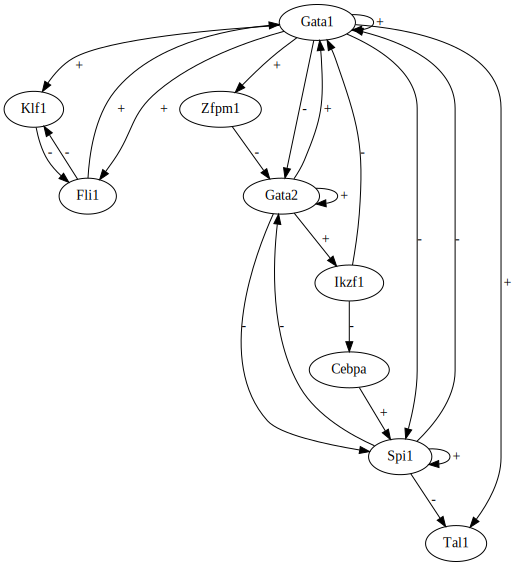

In [10]:
# Creating influence graph Trusted
influenceGraphTableTrusted = influenceGraphTable[influenceGraphTable["Trusted"]==1].copy()
infTrusted = []
for r in influenceGraphTableTrusted.index:
    infTrusted.append((influenceGraphTableTrusted["tf"][r],influenceGraphTableTrusted["target"][r],dict(sign= influenceGraphTableTrusted["mor"][r])))

domTrusted = bonesis.InfluenceGraph(infTrusted, maxclause = 3,exact=False)
domTrusted

In [11]:
len(infTrusted)

22

In [12]:
# Creating influence graph 
inf0 = []
for r in influenceGraphTable.index:
    inf0.append((influenceGraphTable["tf"][r],influenceGraphTable["target"][r],dict(sign= influenceGraphTable["mor"][r])))



## Loading binarized component activities for each HSPC states

These activities and their binarization were computed on scRNA-seq data.

In [13]:
dataTable = pd.read_csv(obsData,index_col = 0)
## Adjustement
dataTable["Myc"].loc["pNeuMast"] =  float('NaN')
dataTable["Myc"].loc["pEr"] =  float('NaN')
dataTable["Myc"].loc["pMk"] =  float('NaN')
dataTable["CDK46CycD"].loc["pMk"] =  float('NaN')
dataTable["Bclaf1"].loc["pLymph"] =  float('NaN')
dataTable["CIPKIP"].loc["pLymph"] =  float('NaN')

dataTable["Egr1"].loc["srHSC"] =  float('NaN')
dataTable["Gata2"].loc["pNeuMast"] =  float('NaN')



data = dataTable.to_dict("index")


clean_data = dict() #Bug of mpbn if nan in dict
for o in data.keys():
    clean_data[o] = {k: data[o][k] for k in data[o] if not isnan(data[o][k])}

data= clean_data
pd.DataFrame(data)

/home/leonard/bin/miniconda3/envs/bonesis_env/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,iHSC,srHSC,qHSC,preDiff,pLymph,pNeuMast,pMk,pEr
Egr1,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0
Junb,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Bclaf1,1.0,1.0,0.0,1.0,NaN,0.0,0.0,0.0
Myc,0.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN
Fli1,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
Gata2,1.0,0.0,1.0,0.0,1.0,NaN,0.0,0.0
Spi1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
Cebpa,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Gata1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
Klf1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Making some adjustements on the binarized data and add mutant HSCP states

Because no solution were obtained with the binarized data outputed from the scRNA-seq analysis, we made some adjustements for certain components in certain HSPC states. See our paper for more details. We also add the  binarized activities for mutant HSPC states observed in our first analysis of a subset of solution (see `solution_space_exploration.ipynb`) that were also characterized experimentally in previous studies.

In [14]:
## add mutant obs
data["G0pMk"] = {
 'Bclaf1': 0.0,
 'Myc': 0,
 'Fli1': 1,
 'Gata2': 0.0,
 'Spi1': 0,
 'Cebpa': 0,
 'Gata1': 1,
 'Klf1': 0,
 'Tal1': 1.0,
 'Ikzf1': 0.0,
 'Zfpm1': 1.0,
 'CIPKIP': 1}

data["G2MpNeuMast"] = {'Egr1': 0.0,
 'Junb': 0,
 'Fli1': 0,
 'Spi1': 1,
 'Cebpa': 1,
 'Gata1': 0,
 'Klf1': 0,
 'Tal1': 0.0,
 'Ikzf1': 0.0,
 'Zfpm1': 0.0,
 'CDK46CycD': 1,
 'CIPKIP': 0.0}



data["zeros"] ={'Egr1': 0.0,
 'Junb': 0,
 'Tal1': 0.0,
 'Bclaf1': 0.0,
 'Myc': 0.0,
 'Fli1': 0.0,
 'Gata2': 0.0,
 'Ikzf1': 0,
 'Spi1': 0,
 'Cebpa': 0,
 'Gata1': 0.0,
 'Klf1': 0,
 'Zfpm1': 0.0,
 'CIPKIP': 0,
 'CDK46CycD': 0.0}



In [15]:
obsData = pd.DataFrame.from_dict(data, orient="index").fillna('')[geneOrder]

#Add some mutant obs

obsData = obsData[geneOrder].reindex(["iHSC", "srHSC", "qHSC","preDiff","pLymph","pNeuMast","pMk","pEr","zeros","G0pMk",'G2MpNeuMast'])

obsData = obsData.transpose()

obsDataView = obsData.style.apply(lambda x: ["background: ligthgrey" if v == "" else  "background: darkred" if v == 1.0 else "background: darkblue" for v in x], axis = 1).apply(lambda x: ["color: lightgrey" if v == "" else  "color: darkred" if v == 1.0 else "color: darkblue" for v in x], axis = 1)

obsDataView.set_precision(0)

,iHSC,srHSC,qHSC,preDiff,pLymph,pNeuMast,pMk,pEr,zeros,G0pMk,G2MpNeuMast
Egr1,0,,1,0,0,0,0,0,0,,0
Junb,0,0,1,0,0,0,0,0,0,,0
Bclaf1,1,1,0,1,,0,0,0,0,0,
Myc,0,0,1,1,0,,,,0,0,
Fli1,1,1,1,0,0,0,1,0,0,1,0
Gata2,1,0,1,0,1,,0,0,0,0,
Spi1,0,0,0,1,1,1,0,0,0,0,1
Cebpa,0,0,0,0,0,1,0,0,0,0,1
Gata1,0,0,0,0,0,0,1,1,0,1,0
Klf1,0,0,0,0,0,0,0,1,0,0,0


# computing graph layout...


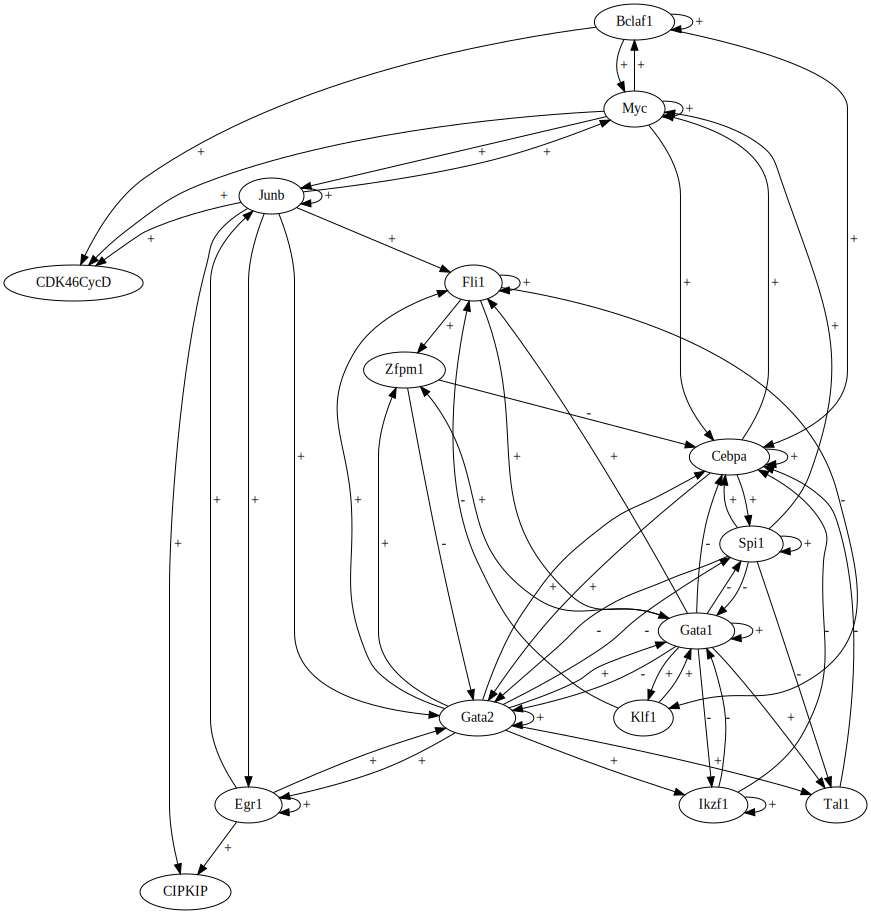

In [16]:
inf = inf0.copy()

dom0 = bonesis.InfluenceGraph(inf, maxclause = 3,exact=False)
allEdges = funForBonesis.multiDiGraphToEdgeList(dom0)
dom0

In [17]:
influenceGraphTable = influenceGraphTable[numpy.logical_not((influenceGraphTable["mor"] == -1) & (influenceGraphTable["tf"] == influenceGraphTable["target"]))]


In [18]:
len(influenceGraphTable)

60

## Inference of optimized solutions
In this second inference step after the first solution space exploration ().
We had constraints on mutant behaviors that matched with previous experimental studies.
We optimize of our solution search with in priority a maximization of high-confident interactions and then a minimization of others.

We define two functions to encode mutant behaviors constraints with Bonesis.

In [19]:
def mutant_constraint(mutation, phenotypes,bo):
    with bo.mutant(mutation) as m:
        # each phenotype can be reached from at least one init
        for ph in phenotypes:
            +m.obs("iHSC") >= m.fixed(+m.obs(ph))
        # each possible initial configuration can only reach fixed points matching with phenotypes
        for cfg in bonesis.matching_configurations(m.obs("iHSC")):
            cfg >> "fixpoints" ^ {m.obs(ph) for ph in phenotypes}

def buildConstraints(inf,data, maxclause = 3,exact =True,parallel=24):
    dom1 = bonesis.InfluenceGraph(inf, maxclause = maxclause,exact=exact)
    bo = bonesis.BoNesis(dom1, data)
    bo.settings["parallel"] = 28
    fLymph = bo.fixed(~bo.obs("pLymph"))
    fEr = bo.fixed(~bo.obs("pEr"));
    fMk = bo.fixed(~bo.obs("pMk"));
    fNeuMast = bo.fixed(~bo.obs("pNeuMast"));
    start = ~bo.obs("iHSC")

    start >= ~bo.obs("srHSC")
    start >= ~bo.obs("qHSC")
    start >= fLymph
    start >= ~bo.obs("preDiff") >= fEr
    start >= ~bo.obs("preDiff") >= fMk
    start >= ~bo.obs("preDiff") >= fNeuMast

    ~bo.obs("srHSC") >= start
    ~bo.obs("qHSC") >= start
    ~bo.obs("preDiff") / ~bo.obs("qHSC")
    ~bo.obs("preDiff") / ~bo.obs("srHSC")
    ~bo.obs("preDiff") / start
    ~bo.obs('zeros') / fNeuMast
    ~bo.obs('zeros') / fMk
    ~bo.obs('zeros') / fEr

    ~bo.obs('zeros') / fLymph
    ~bo.obs("iHSC") >> "fixpoints" ^ {bo.obs(obs) for obs in ["pLymph", "pNeuMast","pEr","pMk","zeros"]};

    mutant_constraint({"Spi1":0}, ["pEr","pMk","zeros"],bo)
    #mutant_constraint({"Cebpa":0}, ["pEr","pMk"],bo)
    mutant_constraint({"Ikzf1":0}, ["pEr","pMk","pNeuMast","zeros"],bo)
    mutant_constraint({"Klf1":0}, ["pMk","pLymph","pNeuMast","zeros"],bo)
    


    mutant_constraint({"Junb":1}, ["G0pMk"],bo)
    mutant_constraint({"Egr1":1}, ["G0pMk"],bo)

    mutant_constraint({"Junb":0}, ["G2MpNeuMast","pEr","pMk","pNeuMast","pLymph","zeros"],bo)
    return bo


First, we conducted an optimized inference with clingo to recover the maximum  number of highly confident interactions and the minimal number of the others in the possible solutions.  

In [20]:

    
bo0 = buildConstraints(inf = dom0,data = data,exact = False,maxclause = 3)


    # In[4]:


view = bo0.boolean_networks()   
filename = "optimization"
view.standalone(output_filename=filename+".asp")
a_file = open(filename+".asp", "r")
list_of_lines = a_file.readlines()


    # In[5]:

Trusted = []
Trusted = ['trustedin("'+ i[0]+'","'+i[1]+'",'+str([*i[2].values()][0])+').\n' for i in infTrusted]
Trusted += ['nTrustedEdges(N,X) :- clause(N,_,_,_),X = #count{L,S: clause(N,_,L,S),trustedin(L,N,S)}.\n',
            'trustedInKept(T) :- T=#sum{V,O: nTrustedEdges(O,V)}.\n',
            '#maximize{N@2:trustedInKept(N)}.\n']

insert_at = len(list_of_lines)-4   # Index starting from which multiple elements will be inserted

insert_elements = Trusted +['% Add an edges number minimization\n',
                    'nedges(N,X) :- clause(N,_,_,_),X = #count{L,S: clause(N,_,L,S),not trustedin(L,N,S)}.\n',
                    'totedges(T) :- T=#sum{V,O: nedges(O,V)}.\n',
                    '#minimize{N@1:totedges(N)}.\n']


list_of_lines[insert_at:insert_at] = insert_elements


    # In[6]:


a_file = open(filename+".asp", "w")
a_file.writelines(list_of_lines)
a_file.close()


In [21]:
solving = funForBonesis.shell(['sh',filename+".asp"])

In [22]:
optima = [s for s in solving[0].split('\\n') if "Optimization" in s][-1].split(':')[1]


maximumEdgesNonTrusted = int(optima.split(" ")[2])
minimumEdgesTrusted = -int(optima.split(" ")[1])

print(maximumEdgesNonTrusted)
print(minimumEdgesTrusted)


13
22


In [23]:
view = bo0.boolean_networks()   
view.standalone(output_filename=filename+".asp")

Then, we inferred all the possible solution that have at least the optimal number of highly confident interaction and at most the optimal number of non hghly confident ones.

In [24]:

view = bo0.boolean_networks()   
filename = "miniEdgeSol"
view.standalone(output_filename=filename+".asp")
a_file = open(filename+".asp", "r")
list_of_lines = a_file.readlines()


    # In[10]:


insert_at = len(list_of_lines)-4   # Index starting from which multiple elements will be inserted

insert_elements = Trusted[0:-3] + ['% Add a non trusted edges number limitation\n',
                    'nedges(N,X) :- clause(N,_,_,_),X = #count{L,S: clause(N,_,L,S),not trustedin(L,N,S)}.\n',
                    'totedges(T) :- T=#sum{V,O: nedges(O,V)}.\n',
                    ':- totedges(T) ; T>'+str(maximumEdgesNonTrusted)+'.\n'] +['% Add a trusted edges number limitation\n',
                    'nTrustedEdges(N,X) :- clause(N,_,_,_),X = #count{L,S: clause(N,_,L,S), trustedin(L,N,S)}.\n',
                    'trustedInKept(T) :- T=#sum{V,O: nTrustedEdges(O,V)}.\n',
                    ':- trustedInKept(T) ; T<'+str(minimumEdgesTrusted)+'.\n']


list_of_lines[insert_at:insert_at] = insert_elements


    # In[11]:


a_file = open(filename+".asp", "w")
a_file.writelines(list_of_lines)
a_file.close()

In [25]:
solving = funForBonesis.shell(['sh',filename+".asp"])

In [26]:

solving = [s for s in solving[0].split('\\n')]
#answerList = [l.strip("\n") for l in answerList]


# In[13]:


answerList = [l for l in solving if l.startswith("clause")]

len(answerList)


    # In[14]:


solutions = [funForBonesis.minibn_of_facts2(funForBonesis.getAnswerDict(sol)) for sol in answerList]


    # In[15]:


#pickle.dump(solutions, open(outDir+"/solutions.p", "wb" ),fix_imports=True,protocol=1 )

In [27]:
len(solutions)

616

We can save this solution set.

In [28]:
pickle.dump(solutions, open("optimized_solutions_test.p", "wb" ),fix_imports=True,protocol=1 )


In [29]:
len(solutions)

616

## Final Inference Step
We perform a final inference by imposing that all interactions found in at least one optimized solution are present in the possible solutions.

# computing graph layout...


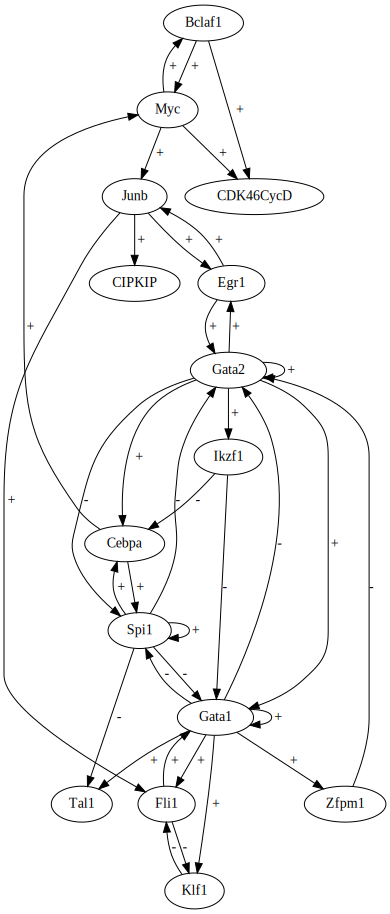

In [30]:
edgeList = []
nEdges = []
for s in solutions:
    nEdges.append(len([e for e in s.influence_graph().edges(data=True) if e not in edgeList]))
    for e in s.influence_graph().edges(data=True):
        edgeList.append(e) if e not in edgeList else edgeList
len(edgeList)

domPossible = bonesis.InfluenceGraph(edgeList, maxclause = 3,exact=False)
domPossible

In [31]:
len(domPossible.edges(data=True))
allEdges = funForBonesis.multiDiGraphToEdgeList(domPossible)
len(allEdges)

36

# computing graph layout...


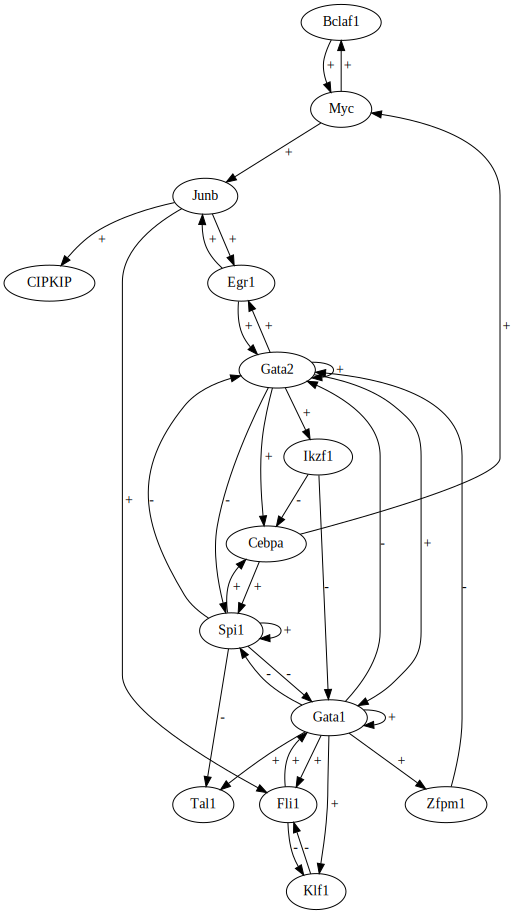

In [32]:
essentialEdges = list(solutions[-1].influence_graph().edges(data=True))
for e in essentialEdges:
    for s in range(len(solutions)-1):
        if e not in solutions[s].influence_graph().edges(data=True):
            essentialEdges.remove(e)
            break
        
  

domEssential = bonesis.InfluenceGraph(essentialEdges, maxclause = 2,exact=False)
domEssential

In [33]:
for i in range(len(essentialEdges)):
    essentialEdges[i][2].pop('label', None)

len(essentialEdges)


34

In [34]:
influenceGraphTable["essential"] = [True if inf[e] in essentialEdges else False for e in range(len(inf))]

In [35]:
influenceGraphTable["solution"] = [True if inf[e] in allEdges else False for e in range(len(inf))]
influenceGraphTable[(influenceGraphTable["essential"] == False) & (influenceGraphTable["solution"] == True)]

,tf,mor,target,ref,interaction_proof_level,cell_line,cell_type_tissue,Trusted,Scenic,cistromeAdjScore,interaction0,essential,solution
0,Bclaf1,1,CDK46CycD,NaN,NaN,NaN,NaN,0,True,NaN,Bclaf1_CDK46CycD,False,True
32,Myc,1,CDK46CycD,NaN,NaN,NaN,NaN,0,True,0.0894,Myc_CDK46CycD,False,True


In [36]:
influenceGraphTable[(influenceGraphTable["essential"] == True)]

,tf,mor,target,ref,interaction_proof_level,cell_line,cell_type_tissue,Trusted,Scenic,cistromeAdjScore,interaction0,essential,solution
2,Bclaf1,1,Myc,NaN,NaN,NaN,NaN,0,True,NaN,Bclaf1_Myc,True,True
5,Cebpa,1,Myc,NaN,NaN,NaN,NaN,0,True,2.982833,Cebpa_Myc,True,True
6,Egr1,1,Junb,NaN,NaN,NaN,NaN,0,True,0.007750,Egr1_Junb,True,True
8,Egr1,1,Gata2,NaN,NaN,NaN,NaN,0,True,0.000000,Egr1_Gata2,True,True
12,Gata1,1,Klf1,Crossley_1994;Krumsiek_2011,transcriptionnal regulation,MEL,NaN,1,True,3.243200,Gata1_Klf1,True,True
13,Gata1,1,Gata1,Tsai_1991;Krumsiek_2011,transcriptionnal_regulation,MEL,NaN,1,True,2.538600,Gata1_Gata1,True,True
14,Gata2,1,Ikzf1,Malinge_2013,transcriptionnal regulation,G1ME,NaN,1,True,0.370300,Gata2_Ikzf1,True,True
17,Gata2,1,Cebpa,Cooper_2015,transcriptionnal regulation (+37 kb enhancer b...,NaN,32Dcl3,0,True,0.010200,Gata2_Cebpa,True,True
18,Gata2,1,Egr1,NaN,NaN,NaN,NaN,0,True,0.108300,Gata2_Egr1,True,True
20,Gata2,1,Gata2,Grass_2003;Krumsiek_2011,transcriptionnal regulation,NaN,HSC,1,True,0.275000,Gata2_Gata2,True,True


In [37]:
finalEdges = allEdges.copy()
#finalEdges = finalEdges.copy()

# computing graph layout...


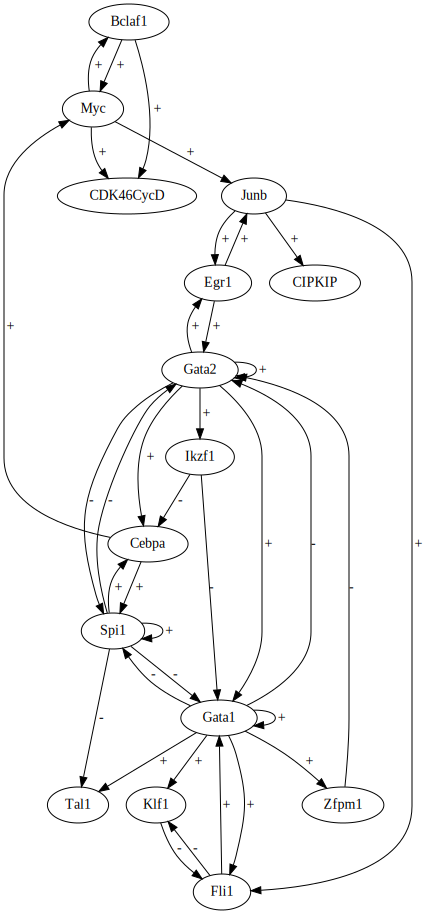

In [38]:
domMini = bonesis.InfluenceGraph(finalEdges, maxclause = 3,exact=True)
domMini

In [39]:
solutions = []
bo1 = buildConstraints(domMini,data = data,exact = True,maxclause = 3)
view = bo1.boolean_networks()
view.standalone(output_filename="secondInfExact.asp")


In [40]:
solutions = []
for bn in bo1.boolean_networks(): # limit is optional
    if(funForBonesis.has_cyclic(bn)):
        print("HAS CYCLIC ATTRACTORS, IGNORING")
        continue
    solutions.append(bn)

print(len(solutions))

Grounding...done in 0.1s
616


We save this final set of solutions.

In [41]:
pickle.dump(solutions, open("possible_final_solutions.p", "wb" ),fix_imports=True,protocol=1 )


In [42]:
table = pd.DataFrame(solutions)
table.sort_values(by=geneOrder, inplace=True)
table[geneOrder]

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
49,Junb&Gata2,Egr1|Myc,Myc,Cebpa&Bclaf1,Junb|(Gata1&!Klf1),(!Gata1&Egr1)|(!Gata1&Gata2)|(Gata2&!Spi1&!Zfpm1),(Spi1&!Gata1)|(!Gata2&Cebpa&!Gata1),(Gata2&!Ikzf1)|(Spi1&!Ikzf1),Fli1|(Gata1&!Ikzf1)|(Gata2&!Spi1),Gata1&!Fli1,Gata1&!Spi1,Gata2,Gata1,Myc&Bclaf1,Junb
221,Junb&Gata2,Egr1|Myc,Myc,Cebpa&Bclaf1,Junb|(Gata1&!Klf1),(!Gata1&Egr1)|(!Gata1&Gata2)|(Gata2&!Spi1&!Zfpm1),(Spi1&!Gata1)|(!Gata2&Cebpa&!Gata1),(Gata2&!Ikzf1)|(Spi1&!Ikzf1),Fli1|(Gata1&!Ikzf1)|(Gata2&!Spi1),Gata1&!Fli1,Gata1&!Spi1,Gata2,Gata1,Bclaf1|Myc,Junb
381,Junb&Gata2,Egr1|Myc,Myc,Cebpa&Bclaf1,Junb|(Gata1&!Klf1),(!Gata1&Egr1)|(!Gata1&Gata2)|(Gata2&!Spi1&!Zfpm1),(Spi1&!Gata1)|(!Gata2&Cebpa&!Gata1),(Gata2&!Ikzf1)|(Spi1&!Ikzf1),Fli1|(Gata2&!Spi1)|(Gata1&!Ikzf1&!Spi1),Gata1&!Fli1,Gata1&!Spi1,Gata2,Gata1,Myc&Bclaf1,Junb
324,Junb&Gata2,Egr1|Myc,Myc,Cebpa&Bclaf1,Junb|(Gata1&!Klf1),(!Gata1&Egr1)|(!Gata1&Gata2)|(Gata2&!Spi1&!Zfpm1),(Spi1&!Gata1)|(!Gata2&Cebpa&!Gata1),(Gata2&!Ikzf1)|(Spi1&!Ikzf1),Fli1|(Gata2&!Spi1)|(Gata1&!Ikzf1&!Spi1),Gata1&!Fli1,Gata1&!Spi1,Gata2,Gata1,Bclaf1|Myc,Junb
445,Junb&Gata2,Egr1|Myc,Myc,Cebpa&Bclaf1,Junb|(Gata1&!Klf1),(!Gata1&Egr1)|(!Gata1&Gata2)|(!Spi1&Gata2&Egr1...,(Spi1&!Gata1)|(!Gata2&Cebpa&!Gata1),(Gata2&!Ikzf1)|(Spi1&!Ikzf1),Fli1|(Gata1&!Ikzf1)|(Gata2&!Spi1),Gata1&!Fli1,Gata1&!Spi1,Gata2,Gata1,Myc&Bclaf1,Junb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,Junb&Gata2,Egr1|Myc,Myc,Cebpa&Bclaf1,(Junb&Gata1)|(Gata1&!Klf1)|(Junb&!Klf1),(!Zfpm1&Egr1)|(Gata2&!Zfpm1)|(!Spi1&!Gata1&Gat...,(Spi1&!Gata1)|(!Gata2&Cebpa&!Gata1),(Gata2&!Ikzf1)|(Spi1&!Ikzf1),Fli1|(Gata2&!Spi1)|(Gata1&!Ikzf1&!Spi1),Gata1&!Fli1,Gata1&!Spi1,Gata2,Gata1,Bclaf1|Myc,Junb
52,Junb&Gata2,Egr1|Myc,Myc,Cebpa&Bclaf1,(Junb&Gata1)|(Gata1&!Klf1)|(Junb&!Klf1),(!Zfpm1&Egr1)|(!Spi1&!Gata1&Egr1)|(!Gata1&Gata...,(Spi1&!Gata1)|(!Gata2&Cebpa&!Gata1),(Gata2&!Ikzf1)|(Spi1&!Ikzf1),Fli1|(Gata1&!Ikzf1)|(Gata2&!Spi1),Gata1&!Fli1,Gata1&!Spi1,Gata2,Gata1,Myc&Bclaf1,Junb
92,Junb&Gata2,Egr1|Myc,Myc,Cebpa&Bclaf1,(Junb&Gata1)|(Gata1&!Klf1)|(Junb&!Klf1),(!Zfpm1&Egr1)|(!Spi1&!Gata1&Egr1)|(!Gata1&Gata...,(Spi1&!Gata1)|(!Gata2&Cebpa&!Gata1),(Gata2&!Ikzf1)|(Spi1&!Ikzf1),Fli1|(Gata1&!Ikzf1)|(Gata2&!Spi1),Gata1&!Fli1,Gata1&!Spi1,Gata2,Gata1,Bclaf1|Myc,Junb
467,Junb&Gata2,Egr1|Myc,Myc,Cebpa&Bclaf1,(Junb&Gata1)|(Gata1&!Klf1)|(Junb&!Klf1),(!Zfpm1&Egr1)|(!Spi1&!Gata1&Egr1)|(!Gata1&Gata...,(Spi1&!Gata1)|(!Gata2&Cebpa&!Gata1),(Gata2&!Ikzf1)|(Spi1&!Ikzf1),Fli1|(Gata2&!Spi1)|(Gata1&!Ikzf1&!Spi1),Gata1&!Fli1,Gata1&!Spi1,Gata2,Gata1,Myc&Bclaf1,Junb


In [43]:
table.nunique()

Bclaf1        1
CDK46CycD     2
CIPKIP        1
Cebpa         1
Egr1          1
Fli1          2
Gata1         2
Gata2        77
Ikzf1         1
Junb          1
Klf1          1
Myc           1
Spi1          1
Tal1          1
Zfpm1         1
dtype: int64

In [44]:
for n in table.nunique().index:
    if table.nunique()[n] > 1:
        print(n)
        print(pd.DataFrame(table[n].unique())) 

CDK46CycD
            0
0  Myc&Bclaf1
1  Bclaf1|Myc
Fli1
                                         0
0                       Junb|(Gata1&!Klf1)
1  (Junb&Gata1)|(Gata1&!Klf1)|(Junb&!Klf1)
Gata1
                                         0
0        Fli1|(Gata1&!Ikzf1)|(Gata2&!Spi1)
1  Fli1|(Gata2&!Spi1)|(Gata1&!Ikzf1&!Spi1)
Gata2
                                                    0
0   (!Gata1&Egr1)|(!Gata1&Gata2)|(Gata2&!Spi1&!Zfpm1)
1   (!Gata1&Egr1)|(!Gata1&Gata2)|(!Spi1&Gata2&Egr1...
2    (!Gata1&Egr1)|(!Gata1&Gata2)|(!Spi1&!Zfpm1&Egr1)
3   (!Gata1&Egr1)|(!Gata1&Gata2&!Spi1)|(!Gata1&Gat...
4   (!Gata1&Egr1)|(!Gata1&Gata2&!Zfpm1)|(Gata2&!Sp...
..                                                ...
72  (!Zfpm1&Egr1)|(!Gata1&Gata2&!Zfpm1)|(!Spi1&!Ga...
73  (!Zfpm1&Egr1)|(Gata2&!Zfpm1)|(!Gata1&Gata2&!Spi1)
74   (!Zfpm1&Egr1)|(Gata2&!Zfpm1)|(!Spi1&!Gata1&Egr1)
75  (!Zfpm1&Egr1)|(Gata2&!Zfpm1)|(!Spi1&!Gata1&Gat...
76  (!Zfpm1&Egr1)|(!Spi1&!Gata1&Egr1)|(!Gata1&Gata...

[77 rows x 1 columns]
